In [58]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, hessian, jit, vmap
from jax.nn import celu
from functools import partial
import time
import optax
import datetime
import itertools
from tqdm import trange
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [59]:
num_particles = 2
sigma = 0
g = 0
hbar = 1
#m = jnp.array([1,1])
m = 1
omegas = jnp.array([1,1])

In [60]:
class Network:
    #[1, 5, 10, 10, 10, 10, 5, 1]
    def __init__(self, node_counts):
        # defining the structure of the neural network
        self.num_layers = len(node_counts)
        # the number of nodes for each layer
        self.node_counts = node_counts
        # the total number of weights
        self.params_length = 0
        
        for i in range(self.num_layers - 1):
            self.params_length += node_counts[i] * node_counts[i + 1]
            i+=1
        # the list that stores the weight matrices (index 0 is the connections from the input to the first hidden layer)
        self.weights = []
        # storage for all the biases
        self.biases = []
        
        # generate weight matrices with the correct sizes, and random elements
        for i in range(self.num_layers - 1):
            self.weights.append(np.random.randn(node_counts[i + 1], node_counts[i]) * np.sqrt(1. / (node_counts[i + 1])))
        self.weights = np.array(self.weights, dtype=object)
        
        # generate the bias arrays
        for i in range(self.num_layers - 1):
            temp = np.random.randn(node_counts[i + 1]) * np.sqrt(1. / node_counts[i + 1])
            self.biases.append(temp[:, None])
        self.biases = np.array(self.biases, dtype=object)
        # get the shape for reshaping a 1d array to this later
        self.dimensions = []
        for m in self.weights:
            self.dimensions.append(m.shape)

    # define the activation function that we use for the layers
    @partial(jit, static_argnums=[0])
    def l_act(self, x):
        return celu(x)
        
    # define the activation function for the output
    @partial(jit, static_argnums=[0])
    def o_act(self, x):
        return celu(x)
    
    @partial(jit, static_argnums=(0,))
    def conv1d(self):
        flattened = []
        # loop through each matrix
        for m in range(self.num_layers - 1):
            mat = self.weights[m]
            for i in range(mat.shape[0]):
                for j in range(mat.shape[1]):
                    flattened.append(mat[i][j])
        for m in range(self.num_layers - 1):
            # add the biases onto the end
            bias = self.biases[m]
            for element in bias:
                flattened.append(element)
        return jnp.array(flattened)
        
    @partial(jit, static_argnums=(0,))
    def convnd(self, params):
        ret = []
        ret_bias = []
        # the last index of the matrix
        max_ind = 0
        prev_ind = 0
        for dim in self.dimensions:
            max_ind += dim[0]*dim[1]
            temp = params[prev_ind : max_ind]
            prev_ind = max_ind
            ret.append(jnp.array(temp).reshape(dim))
        biases_flattened = params[max_ind :]
        # now reconstruct the bias matrices
        # print(biases_flattened)
        ind = 0
        for i in range(self.num_layers - 1):
            ret_bias.append((biases_flattened[ind: ind + self.node_counts[i + 1]])[:, None])
            ind += self.node_counts[i + 1]
        return ret, ret_bias

    # uses the Newton-Girard formula to transform the set of coordinates
    # into something that is invariant under particle swap
    @partial(jit, static_argnums=[0])
    def transform(self, coords):
        ret = jnp.zeros(num_particles)
        for i in range(num_particles):
            ret = ret.at[i].set(jnp.sum(coords**i))
        return ret
    # @partial(jit, static_argnums=[0])
    # def transform(self, coords):
    #     return jnp.sort(coords)
    
    # passing inputs into the neural network and getting an output
    #@partial(jit, static_argnums=[0])
    def output(self, coords, params):
        temp = [[-1]]
        # format the parameters as weights
        c = self.convnd(params)
        self.weights = c[0]
        self.biases = c[1]
        # compute the output of the neural network
        for i in range(self.num_layers - 1):
            w = jnp.array(self.weights[i])
            b = jnp.array(self.biases[i])
            # print(w)
            # print(b)
            # if its the first layer, dot it against the input and use the activation function
            if i == 0:
                temp = self.l_act(jnp.dot(w, coords))
            elif (i < self.num_layers):
                # otherwise dot it against the previous layer and use the activation function
                temp = self.l_act(jnp.dot(w, temp) + b)
            else:
                # on the output layer we use the output activation function
                temp = self.o_act(jnp.dot(w, temp) + b)
        # print("output:" + str(time.time() -  start))
        return temp[0][0]

In [61]:
# create the network object
# sym_length = int(np.math.factorial(num_particles)/(2*np.math.factorial(num_particles - 2)) * num_particles)
# nn = Network([sym_length, 75, 1])
nn = Network([2, 50, 1])

@jit
def psi(coords, params):
    # return jnp.exp(-nn.output(symmetrization(coords), params)[0]) * (jnp.exp(-jnp.sum(coords**2)))
    return jnp.exp(-nn.output(nn.transform(coords), params)) * (jnp.exp(-jnp.sum(coords**2)))
    # return jnp.exp(-nn.output(coords, params)) * (jnp.exp(-jnp.sum(coords**2)))

@jit
def sample_body(coords_t, params, key):    
    gen_rand = jax.random.uniform(key, minval=-5, maxval=5, shape=(num_particles,))
    new_key, subkey = jax.random.split(key)
    
    coords_prime = coords_t + gen_rand
    temp_rand = jax.random.uniform(subkey, minval=0, maxval=1)
    return (jax.lax.cond(temp_rand < psi(coords_prime, params)**2/psi(coords_t, params)**2, lambda x, _: x, lambda _, y : y, coords_prime, coords_t), new_key)


def sample(params, num_samples=10**3, thermalization_steps=200, skip_count=10, key=jax.random.PRNGKey(np.random.randint(0,100))):
    outputs = []
    # e_plots = []
    coords_t = np.random.uniform(-5, 5, num_particles)
    for step in range(num_samples*skip_count + thermalization_steps + 1):
        coords_t, key = sample_body(coords_t, params, key)
        if ((step > thermalization_steps) & (step % skip_count == 0)):
            outputs.append(coords_t)
    return jnp.array(outputs)

@jit
def aux_dist(coord, samples):
    # get all of the x_2 coordinates 
    y_star = jnp.sort(samples[:,1])[int(len(samples) * .99)]
    epsilon = 10**(-10)
    alpha = jnp.sqrt(-jnp.log(epsilon)*y_star**2)
    return 1/(alpha * jnp.sqrt(jnp.pi))*jnp.exp(-coord**2/alpha**2)

h = hessian(psi)
@jit
def ddpsi(coords, params):
    return jnp.diagonal(h(coords, params))

@jit
def Hpsi(coords, params):
    # kinetic = - hbar**2 / (2*m) * jnp.sum(ddpsi(coords, params)) * 1/psi(coords, params)
    kinetic = 
    potential = jnp.sum(m*.5*jnp.multiply(omegas**2,coords**2))
    #potential = m/2 * omegas[0]**2 *(coords[0] + coords[1])**2 + m/2 * omegas[1]**2 *(coords[0] - coords[1])**2
    return kinetic + potential

venergy = jit(vmap(Hpsi, in_axes=(0, None), out_axes=0))

@jit
def delta_1(coords):
    # thanks chatGPT for this one
    # create a mask to ensure that j is less than i
    mask = jnp.tril_indices(n=num_particles, k=-1)
    # compute the absolute difference between particle coordinates
    diff = jnp.abs(coords[mask[0]] - coords[mask[1]])
    # sum the pairwise differences and multiply by sigma
    return sigma * jnp.sum(diff, axis=0)

vdelta_1 = jit(vmap(delta_1, in_axes=(0), out_axes=0))

@jit
def delta_2(coords, params, samples):
    mod_coord = coords
    mod_coord = mod_coord.at[1].set(mod_coord[0])
    return g/2 * num_particles * (num_particles - 1) * aux_dist(coords[1], samples) * (psi(mod_coord, params))/(psi(coords, params))

vdelta_2 = jit(vmap(delta_2, in_axes=(0,None,None), out_axes=0))

# computes the energy of a given set of parameters
def E(params, num_samples=10**3):
    samples = sample(params, num_samples)
    return (jnp.sum(venergy(samples, params)) + jnp.sum(vdelta_1(samples)) + jnp.sum(vdelta_2(samples, params, samples)))/ num_samples

# vectorized derivative calculation
@jit
def dfdtheta(coords, params):
    return grad(nn.output, argnums=1)(coords, params)

vdfdtheta = jit(vmap(dfdtheta, in_axes=(0, None), out_axes=0))

# computes the gradient of the average energy
def gradient(params, num_samples=10**3, verbose=True):
    # get the samples
    samples = sample(params, num_samples)
    # compute all the different parts that go into the gradient
    gradient_ret = 0
    tmpves = venergy(samples, params)
    ves = jnp.sum(tmpves)
    uncert = jnp.std(tmpves)/np.sqrt(num_samples)

    delta1s = jnp.sum(vdelta_1(samples))
    delta2s = jnp.sum(vdelta_2(samples, params, samples))
    
    energy = (ves + delta1s + delta2s)/ num_samples
    if verbose:
        print(energy)
    #TODO: multiply by distribution
    eratio = jnp.sum(vdelta_2(samples, params, samples))
    derivatives = jnp.sum(vdfdtheta(samples, params))
    
    gradient_ret += 2 * energy * derivatives/num_samples
    gradient_ret -= 2 * (derivatives * delta1s)/num_samples
    #TODO: second derivatives is wrong
    gradient_ret -= (g * num_particles * (num_particles - 1)) * (derivatives * eratio)/num_samples

    return gradient_ret, energy, uncert


def adam_opt(params, optimizer, num_samples=10**3, max_iterations=100, t1=50, t2=75, high_res=10**4,higher_res= 10**5, verbose=False):
    hist = []
    uncertainties = []
    opt_state = optimizer.init(params)
    start = time.time()
    def step(params, opt_state, num_samples):
        if verbose:
            clear_output(wait=True)
        gr = gradient(params, num_samples, verbose=verbose)
        hist.append(gr[1])
        uncertainties.append(gr[2])
        updates, opt_state = optimizer.update(gr[0], opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, gr[1]
    
    pbar = trange(max_iterations,desc="", leave=True)
    for step_num in pbar:   
        if step_num > t2:
            params, opt_state, energy = step(params, opt_state, higher_res)
        elif (step_num > t1):
            params, opt_state, energy = step(params, opt_state, high_res)
        else:
            params, opt_state, energy = step(params, opt_state, num_samples)
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
        
    
    elapsed = time.time() - start
    if verbose:
        print("Iterations per second: " + str(elapsed/max_iterations))
    return hist, uncertainties


In [62]:
# determine the autocorrelation time of a given set of samples
def autocorrelation(samples):
    mean = jnp.mean(samples)
    var = jnp.var(samples)
    autocorr = []
    for tau in range(1, len(samples)):
        autocorr.append(jnp.mean((samples[:len(samples)-tau] - mean)*(samples[tau:] - mean))/var)
    return autocorr

In [63]:
def optimize(start_params, runs):
    # unpack the information about the different runs
    num_runs = len(runs)
    learning_rates = list(list(zip(*runs))[0])
    iterations = list(list(zip(*runs))[1])
    num_samples = list(list(zip(*runs))[2])

    # inner function for an adam call
    def adam(params, iterations, N, optimizer):
        hs = []
        us = []
        opt_state = optimizer.init(params)
        
        def step(params, opt_state, N):
            gr = gradient(params, N)
            hs.append(gr[1])
            us.append(gr[2])
            updates, opt_state = optimizer.update(gr[0], opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, gr[1]

        pbar = trange(iterations, desc="", leave=True)
        for step_num in pbar:   
            params, opt_state, energy = step(params, opt_state, N)
            pbar.set_description("Energy = " + str(energy), refresh=True)
            if np.isnan(energy):
                print("NaN encountered, stopping...")
                break
            clear_output(wait=True)
        return hs, us, params
    # calls the inner function multiple times, with the different learning rates, and for different iterations
    start_time = time.time()
    hists = []
    uncerts = []
    curr_params = start_params
    for i in range(num_runs):
        # clear the screen
        # clear_output(wait=True)
        curr_hs, curr_us, curr_params = adam(curr_params, iterations[i], num_samples[i], optax.adam(learning_rate=learning_rates[i]))
        # tack on the outputs to what we already have
        hists += curr_hs
        uncerts += curr_us
    return hists, uncerts, time.time() - start_time

def plot_optimization(hists, uncerts, elapsed_time, runs=None):
    # simple harmonic potentials
    true_energy = np.sum(hbar/2 * omegas)
    # two particle with nontrivial interaction
    #true_energy = np.sqrt(2)/2 *(np.sum(omegas))

    # plt.title(r"Two Particles in Harmonic Potential ($\vec{\omega} = $" + str(omegas) + r")")
    plt.title(r"Modified LL model ($\delta$ function testing)" + str(omegas))
    plt.xlabel("Iteration of Gradient Descent")
    plt.ylabel("Average Energy")

    # get the network structure
    structure = nn.node_counts
    plt.annotate(" Network Structure: " + str(structure), xy=(0.1, 0.95), xycoords='axes fraction')



    # now plot the adam optimizer run
    plt.plot(np.arange(0, len(hists)), hists, label="Adam, " + str(round(hists[-1],3)) + " +/- " + str(round(uncerts[-1], 2)))
    # plot the uncertainties
    a_hists = np.array(hists)
    a_uncerts = np.array(uncerts)
    plt.fill_between(np.arange(0,len(hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
    # plot the line for the true ground state energy
 
    plt.plot(np.arange(0, len(hists)), [true_energy for x in np.arange(0, len(hists))], label=r"True Energy, " + str(round(true_energy,3)))
    pdiff = (hists[-1] - true_energy)/true_energy*100

    plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
    plt.annotate(" Time taken: " + str(datetime.timedelta(seconds=elapsed_time)).split('.')[0] ,xy=(.1, .85), xycoords= 'axes fraction')
    if runs != None:
        iterations = np.cumsum(list(list(zip(*runs))[1]))
        plt.scatter(iterations, [true_energy]*len(iterations), marker="o", zorder=3, c='red')
    plt.legend(fontsize=7)
    plt.show()



In [64]:
# runs = [[.1, 20, 10**4],[.1, 30, 10**4]]
runs = [[.01, 100, 10**4]]
# runs = [[.1, 50, 10**4],[.1, 50, 2*10**4], [.01, 50, 4*10**4],[.001, 50, 8*10**4],[.01, 50, 16*10**4]]
hists, uncerts, elapsed_time = optimize(nn.conv1d(), runs)

Energy = 6.5865307: 100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


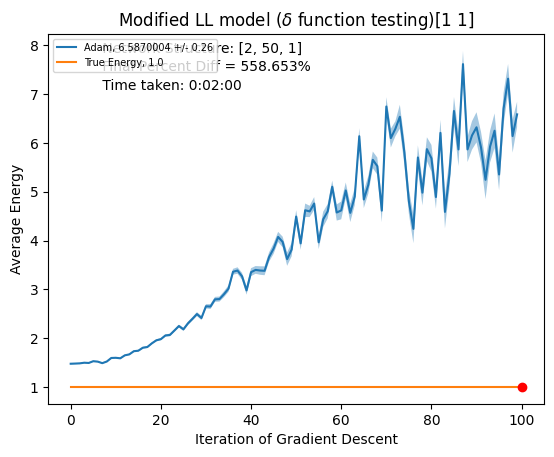

In [65]:
plot_optimization(hists, uncerts, elapsed_time, runs=runs)